In [1]:
#install these libraries into the environment to make this work
#!pip install h3
#!pip install Rtree
#!pip install pygeos
#!pip install geopandas
#!conda install fiona shapely pyproj rtree
#!pip install geojson

In [2]:
#!python3 -V

In [3]:
import logging
import os
import warnings
##for database connection
import cx_Oracle
import ads
from ads.database import connection 
from ads.database.connection import Connector
from ads.dataset.factory import DatasetFactory
from urllib.request import urlopen
from sqlalchemy import create_engine

##warnings.filterwarnings("ignore", category=DeprecationWarning) 
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)
warnings.filterwarnings("ignore")

/home/datascience/conda/dataexplorationandmanipulationforcpupython3_7v3_0/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [4]:
# import libraries
import geopandas as gpd
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import rtree
import h3
import folium
from geojson import Feature, Point, FeatureCollection
import json

In [5]:
database_name = "ADB01"
#connection.get_repository(key=database_name)

wallet_path = os.path.join(os.path.expanduser("~"), f"Wallet_{database_name}.zip")

if database_name != "<database_name>":
    connection.import_wallet(wallet_path=wallet_path, key=database_name)
    
connector = Connector(key=database_name)

connector.connect()

In [6]:
# Query data
# remove planes_new to planes
PLANES = """
    SELECT
        EPOCH_TIME,
        ICAO24,
        CALLSIGN,
        ORIGIN_COUNTRY,
        TIME_POSITION,
        LAST_CONTACT,
        LONGITUDE,
        LATITUDE,
        BARO_ALTITUDE,
        ON_GROUND,
        VELOCITY,
        TRUE_TRACK,
        VERTICAL_RATE,
        SENSORS,
        GEO_ALTITUDE,
        SQUAWK,
        SPI,
        POSITION_SOURCE,
        STUDIO_ID
    FROM 
        ANALYST.PLANES
    WHERE
        ORIGIN_COUNTRY = 'United States' 
    FETCH FIRST 1000000 rows ONLY
    """

In [7]:
# Make a connection to the Engine and run a query
engine = create_engine(connector.uri)
sql_ais = PLANES
data = pd.read_sql(sql_ais, con=engine)
print(type(data))
print(len(data))

<class 'pandas.core.frame.DataFrame'>
1000000


In [8]:
data.head(3)

,epoch_time,icao24,callsign,origin_country,time_position,last_contact,longitude,latitude,baro_altitude,on_ground,velocity,true_track,vertical_rate,sensors,geo_altitude,squawk,spi,position_source,studio_id
0,2022-02-02 14:37:00,a360ea,ATN9709,United States,2022-02-02 14:31:39,2022-02-02 14:31:54,-82.5409,28.0071,30.48,false,67.94,181.74,-3.25,None,76.20,2370,false,0,59589
1,2022-02-02 14:37:00,a8db55,N67WB,United States,2022-02-02 14:37:00,2022-02-02 14:37:00,-93.6222,43.0675,13106.40,false,232.90,262.64,0.33,None,12893.04,1536,false,0,59590
2,2022-02-02 14:37:00,ae68b1,RCH1044,United States,2022-02-02 14:34:54,2022-02-02 14:34:58,-25.9833,64.5229,7917.18,false,144.38,281.51,0.00,None,7322.82,3006,false,0,59591


In [9]:
# import data
#data = pd.read_csv("data/data.csv")
#data.head(3)

In [10]:
# extract only needed data
df = data[['epoch_time', 'latitude', 'longitude', 'icao24']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   epoch_time  1000000 non-null  datetime64[ns]
 1   latitude    1000000 non-null  float64       
 2   longitude   1000000 non-null  float64       
 3   icao24      1000000 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 30.5+ MB


In [11]:
# Create plot of all plane events 
#df.plot(x='longitude',y='latitude',style='.',alpha=0.2,figsize=(6,6));

In [12]:
# Create plot of all plane events 
#plt.figure(figsize=(12,12))
#plt.scatter(df['longitude'], df['latitude']*0.0001, alpha=0.5)
#plt.show()

In [13]:
#country_boundary_us = gpd.read_file('cb_2018_us_nation_5m.shp')
#country_boundary_us.crs

In [14]:
# create geodataframe and project to WGCS
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf = gdf.set_crs("EPSG:4326")
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [15]:
# use world file that comes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')) 
#world.head(1)

In [16]:
# check project of world files.  Ensure projections on both files match
world.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [17]:
# subset only North America
country = world[world['continent'] == 'North America']

<AxesSubplot:>

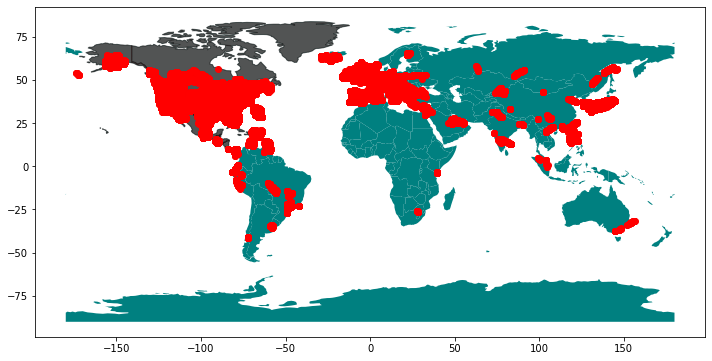

In [18]:
# check data on map 
fig, ax = plt.subplots(figsize=(12,10))
world.plot(ax=ax)
country.plot(ax=ax, edgecolor='black', color = 'brown', alpha=0.5)
gdf.plot(ax=ax, color='Red')

In [19]:
# perform clip with geopandas
clipped = gpd.clip(gdf, country)
clipped.shape

(899401, 5)

<AxesSubplot:>

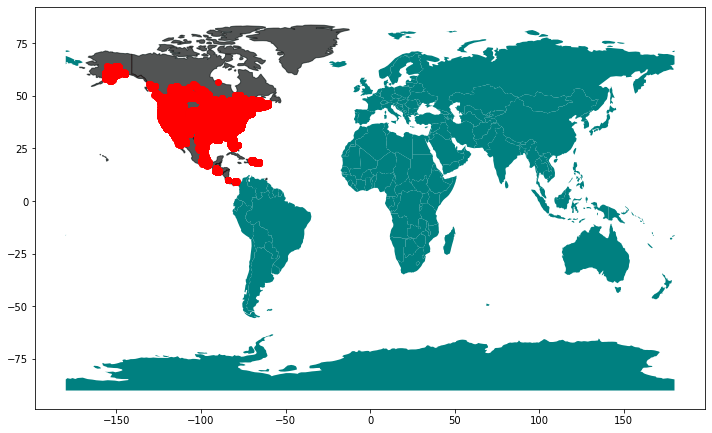

In [20]:
# check data on map
fig, ax = plt.subplots(figsize=(12,10))
world.plot(ax=ax)
country.plot(ax=ax, edgecolor='black', color = 'brown', alpha=0.5)
clipped.plot(ax=ax, color='Red')

In [21]:
# recommended optional: remove unnecessary tables.  This will error if the variables are already deleted.
del world, data, df

In [22]:
#dir()

In [23]:
# check that H3 is actually working; expected to print '831f90fffffffff'
lat, lng, res= 46, 4, 3
h3.geo_to_h3(lat, lng, res)

'831f90fffffffff'

In [24]:
# set clipped to new dataframe
df = clipped
del clipped
#!!!set the hexmap resolution here!!!
# for all data points with lat/long, we add the corresponding hex_id
# lower resolutions = larger hexagons; something like 3-6 is a reasonable range
hex_ids = df.apply(lambda row: h3.geo_to_h3(row.latitude, row.longitude, resolution=3), axis = 1)

# finally set everything to df
df = df.assign(hex_id=hex_ids.values)

In [25]:
# check number of unique hexagons 
hex_ids.nunique()

859

In [26]:
# df should match
df["hex_id"].nunique()

859

In [27]:
# required: count up the populations per hex_id.  Using sum will not work.
dfbyhexid = df.groupby("hex_id", as_index=False).agg({"icao24": "count"})

In [28]:
# check output to make sure it is correct
dfbyhexid.columns = ["hex_id", "value"]
dfbyhexid.head(3)

,hex_id,value
0,830c08fffffffff,3
1,830c09fffffffff,12
2,830c0bfffffffff,57


In [29]:
# map populations per hexagon to percentiles instead, to ensure we get good use of our colour range!
import scipy.stats as scs

In [30]:
#dfbyhexid["value"] = dfbyhexid.value.astype(float)

In [31]:
dfbyhexid.dtypes

hex_id    object
value      int64
dtype: object

In [32]:
dfbyhexid["percentile"] = [scs.percentileofscore(dfbyhexid["value"].values, i) 
                           for i in dfbyhexid["value"].values]

In [33]:
dfbyhexid.head()

,hex_id,value,percentile
0,830c08fffffffff,3,3.608847
1,830c09fffffffff,12,12.456345
2,830c0bfffffffff,57,27.182771
3,830c0cfffffffff,15,14.435390
4,830c0dfffffffff,41,23.864959


In [34]:
# not necessary: sort the values to see if everything looks correct.  
dfbyhexid.sort_values(by = "value", ascending = False, inplace = True)
dfbyhexid.head()

,hex_id,value,percentile
814,8348ebfffffffff,20545,100.000000
677,8344a9fffffffff,16504,99.883586
496,832a10fffffffff,15882,99.767171
631,83441afffffffff,13160,99.650757
683,8344c1fffffffff,12076,99.534342


In [35]:
# This is the function that brings it all together.  Don't mess with this.
def hexagons_dataframe_to_geojson(dfbyhexid, file_output = None, column_name = "value"):
    """
    Produce the GeoJSON for a dataframe, constructing the geometry from the "hex_id" column
    and with a property matching the one in column_name
    """    
    list_features = []
    
    for i,row in dfbyhexid.iterrows():
        try:
            geometry_for_row = { "type" : "Polygon", "coordinates": [h3.h3_to_geo_boundary(h=row["hex_id"],geo_json=True)]}
            feature = Feature(geometry = geometry_for_row , id=row["hex_id"], properties = {column_name : row[column_name]})
            list_features.append(feature)
        except:
            print("An exception occurred for hex " + row["hex_id"]) 

    feat_collection = FeatureCollection(list_features)
    geojson_result = json.dumps(feat_collection)
    return geojson_result

def get_color(custom_cm, val, vmin, vmax):
    return matplotlib.colors.to_hex(custom_cm((val-vmin)/(vmax-vmin)))

def choropleth_map(df_aggreg, column_name = "value", border_color = 'black', fill_opacity = 0.7, color_map_name = "Blues", initial_map = None):
    """
    Creates choropleth maps given the aggregated data. initial_map can be an existing map to draw on top of.
    """    
    #colormap
    min_value = df_aggreg[column_name].min()
    max_value = df_aggreg[column_name].max()
    mean_value = df_aggreg[column_name].mean()
    print(f"Colour column min value {min_value}, max value {max_value}, mean value {mean_value}")
    print(f"Hexagon cell count: {df_aggreg['hex_id'].nunique()}")
    
    # the name of the layer just needs to be unique, put something silly there for now:
    name_layer = "Choropleth " + str(df_aggreg)
    
    if initial_map is None:
        initial_map = folium.Map(location= [37.0902,-95.7129], zoom_start=3, tiles="cartodbpositron")

    #create geojson data from dataframe
    geojson_data = hexagons_dataframe_to_geojson(dfbyhexid = df_aggreg, column_name = column_name)

    # color_map_name 'Blues' for now, many more at https://matplotlib.org/stable/tutorials/colors/colormaps.html to choose from!
    custom_cm = matplotlib.cm.get_cmap(color_map_name)

    folium.GeoJson(
        geojson_data,
        style_function=lambda feature: {
            'fillColor': get_color(custom_cm, feature['properties'][column_name], vmin=min_value, vmax=max_value),
            'color': border_color,
            'weight': 1,
            'fillOpacity': fill_opacity 
        }, 
        name = name_layer
    ).add_to(initial_map)

    return initial_map

In [36]:
# create hexmap
hexmap = choropleth_map(df_aggreg = dfbyhexid, color_map_name = "Blues", column_name = "value")
hexmap #uncomment to plot within notebook

Colour column min value 1, max value 20545, mean value 1047.0325960419093
Hexagon cell count: 859


In [37]:
# save map to file
hexmap.save("output/hexmap.html")
#write to geojson
dfbyhexid.to_json("output/dfbyhexid.geojson")